In [1]:
!pip install transformers --q
!pip install datasets --q
!pip install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio===0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html --q
!pip install pytorch-lightning --q
!pip install torchmetrics --q

# Download the dataset from Gdrive

In [6]:
!pip install --upgrade --force-reinstall gdown --q
# import gdown

# https://drive.google.com/drive/folders/11mRvsHAkggFEJvG4axH4mmWI6FHMQp7X?usp=sharing

!gdown --folder https://drive.google.com/drive/folders/11mRvsHAkggFEJvG4axH4mmWI6FHMQp7X?usp=sharing --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.0.0 requires tangled-up-in-unicode==0.1.0, but you have tangled-up-in-unicode 0.2.0 which is incompatible.


In [7]:
# Google Cloud Notebook
!pip install --upgrade --force-reinstall gdown --q
NELA_2018_SITE_SPLIT = 'nela_gt_2018_site_split/'

!gdown --folder https://drive.google.com/drive/folders/11mRvsHAkggFEJvG4axH4mmWI6FHMQp7X?usp=sharing -O {NELA_2018_SITE_SPLIT} --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.0.0 requires tangled-up-in-unicode==0.1.0, but you have tangled-up-in-unicode 0.2.0 which is incompatible.


# Load the JSON files

In [ ]:
import os
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import json
import numpy as np

def jsonl_to_df(file_path):
    with open(file_path) as f:
        lines = f.read().splitlines()

    df_inter = pd.DataFrame(lines)
    df_inter.columns = ['json_element']

    df_inter['json_element'].apply(json.loads)

    return pd.json_normalize(df_inter['json_element'].apply(json.loads))

In [9]:
NELA_2018_SITE_SPLIT = 'nela_gt_2018_site_split/'

train_df = jsonl_to_df(NELA_2018_SITE_SPLIT + 'train.jsonl')
train_df['split'] = 'train'
dev_df = jsonl_to_df(NELA_2018_SITE_SPLIT + 'dev.jsonl')
dev_df['split'] = 'dev'
test_df = jsonl_to_df(NELA_2018_SITE_SPLIT + 'test.jsonl')
test_df['split'] = 'test'

df = pd.concat([train_df, dev_df, test_df])

In [10]:
table = pd.pivot_table(df, values='title', index=['split'], columns=['label'], aggfunc='count', margins='all')
table

label,0,1,All
split,,,
dev,20294,20294,40588
test,19410,19410,38820
train,35302,35302,70604
All,75006,75006,150012


In [11]:
df.fillna('', inplace=True)
df.sample(5)

,content,title,date,source,label,split
28194,"The far-left Stasi, whose mean-girl column is ...",Daily News Writer Tells Puerto Rican Kimberly ...,2018-06-13,breitbart,0,dev
29023,Theresa May is attempting to get her top team ...,Brexit Theresa May seeks cabinet unity ahead o...,2018-10-16,bbcuk,1,train
45303,As the push towards 5G-powered Smart surveilla...,New FCC Ruling Gives the Government Control of...,2018-10-01,theantimedia,0,train
19099,(Natural News) Scientists from the Chongqing U...,Lotus seeds shown to improve hypertensive cond...,2018-11-16,naturalnews,0,test
4149,(Natural News) The criminal arrest of a high-l...,Stunning arrest of deep state official reveals...,2018-10-17,naturalnews,0,test


# BERT (Title Only)

In [12]:
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModelForSequenceClassification, BertModel, AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import classification_report, confusion_matrix

from collections import defaultdict

_ = torch.manual_seed(42)

In [13]:
MODEL_NAME = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [15]:
bert_model = BertModel.from_pretrained(MODEL_NAME, return_dict = True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Dataset/DataLoader Declaration

In [16]:
class ReliableNews(Dataset):
  def __init__(self, data, tokenizer, max_token_len = 128):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    data_row = self.data.iloc[index]
    title = data_row.title
    labels = data_row.label

    encoding = self.tokenizer.encode_plus(
        title,
        add_special_tokens=True,
        max_length = self.max_token_len,
        return_token_type_ids = False,
        padding = 'max_length',
        truncation = True,
        return_attention_mask = True,
        return_tensors = 'pt'
    )

    return dict(
        title = title,
        input_ids = encoding['input_ids'].flatten(),
        attention_mask = encoding['attention_mask'].flatten(),
        labels = torch.tensor(labels, dtype=torch.float32)
    )

def create_data_loader(df, tokenizer, max_len, batch_size, shuffle=False):
  ds = ReliableNews(
    df,
    tokenizer,
    max_token_len = max_len
  )

  return DataLoader(ds, batch_size = batch_size, shuffle = shuffle)

## Model Declaration

In [17]:
class ReliableNewsClassifier(nn.Module):
  def __init__(self, n_classes):
    super(ReliableNewsClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(MODEL_NAME)
    self.drop = nn.Dropout(p=0.1)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    x = self.bert(input_ids = input_ids, attention_mask = attention_mask)
    output = self.drop(x.pooler_output)
    return self.out(output)

## Early Stopping Declaration

In [ ]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_acc = None
        self.early_stop = False
    def __call__(self, val_acc):
        if self.best_acc == None:
            self.best_acc = val_acc
        elif val_acc - self.best_acc > self.min_delta:
            self.best_acc = val_acc
            # reset counter if validation loss improves
            self.counter = 0
        elif val_acc - self.best_acc < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

## Training Set up

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [21]:
MAX_LEN = 128
BATCH_SIZE = 8

# Use these for prototyping
# train_df = df[df['split']=='train'].sample(10000)
# dev_df = df[df['split']=='dev'].sample(2000)
# test_df = df[df['split']=='test'].sample(2000)

# Normal Split prototype
from sklearn.model_selection import train_test_split
sample_df = df.sample(10000)

train_df, dev_df = train_test_split(sample_df, test_size = 0.4, random_state=42)
dev_df, test_df = train_test_split(dev_df, test_size = 0.5, random_state=42)

# train_df = df[df['split']=='train']
# dev_df = df[df['split']=='dev']
# test_df = df[df['split']=='test']

train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE, shuffle=True)
val_data_loader = create_data_loader(dev_df, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

print(f'total: {sample_df.shape} train: {train_df.shape} val: {dev_df.shape} test: {test_df.shape}')

total: (10000, 6) train: (6000, 6) val: (2000, 6) test: (2000, 6)


In [22]:
model = ReliableNewsClassifier(n_classes = 1)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
EPOCHS =10

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = total_steps//10,
    num_training_steps = total_steps
)

criterion = nn.BCEWithLogitsLoss().to(device)

## Train functions

In [25]:
def train_epoch(model, data_loader, criterion, optimizer, device, scheduler, n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0
  loop = tqdm(data_loader)
  for idx, batch in enumerate(loop):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['labels'].to(device).unsqueeze(1)

    outputs = model(input_ids = input_ids, attention_mask = attention_mask)

    preds = torch.round(torch.sigmoid(outputs))
    loss = criterion(outputs, labels)

    correct_predictions += (preds == labels).sum().item()
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    loop.set_postfix(train_loss = np.mean(losses), train_acc = float(correct_predictions/n_examples))

  return correct_predictions/n_examples, np.mean(losses)

def eval_model(model, data_loader, criterion, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    loop = tqdm(data_loader)
    for idx, batch in enumerate(loop):
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device).unsqueeze(1)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.round(torch.sigmoid(outputs))

      loss = criterion(outputs, labels)

      # correct_predictions += torch.sum(preds == labels.unsqueeze(1))
      correct_predictions += (preds == labels).sum().item()
      losses.append(loss.item())

      loop.set_postfix(val_loss = np.mean(losses), val_acc = float(correct_predictions/n_examples))

  return correct_predictions / n_examples, np.mean(losses)

## Training Loop

In [ ]:
history = defaultdict(list)
best_accuracy = 0
early_stopping = EarlyStopping(patience=3)

for epoch in range(EPOCHS):
  print(f'Epoch: {epoch+1}/{EPOCHS}')
  print('-' * 10)

  # Training Step
  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      criterion,
      optimizer,
      device,
      scheduler,
      len(train_df)
  )

  # Validation Step
  val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      criterion,
      device,
      len(dev_df)
  )

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_' + MODEL_NAME + '_state.bin')
    best_accuracy = val_acc

  # early_stopping(val_loss)
  # if early_stopping.early_stop:
  #     break

Epoch: 1/10
----------


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 2/10
----------


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 3/10
----------


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 4/10
----------


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 5/10
----------


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 6/10
----------


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 7/10
----------


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Epoch: 8/10
----------


  0%|          | 0/750 [00:00<?, ?it/s]

## Model Evaluation

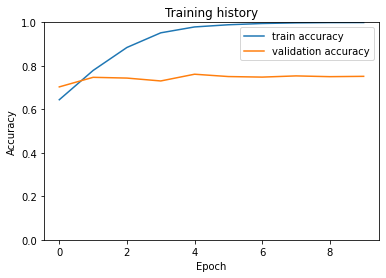

In [114]:
import matplotlib.pyplot as plt

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

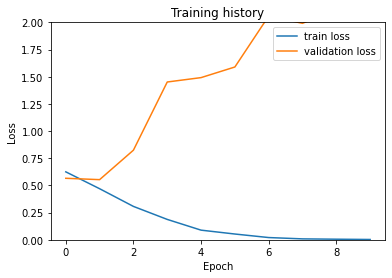

In [115]:
import matplotlib.pyplot as plt

plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 2]);

In [116]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  criterion,
  device,
  len(test_df)
)

test_acc

  0%|          | 0/200 [00:00<?, ?it/s]

0.756875

In [104]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    loop = tqdm(data_loader)
    for idx, d in enumerate(loop):

      texts = d["title"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.round(torch.sigmoid(outputs))

      # probs = nn.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      # prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  # prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, real_values

In [117]:
y_review_texts, y_pred, y_test = get_predictions(
  model,
  test_data_loader
)

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
y_pred

In [118]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.79      0.77       811
         1.0       0.77      0.72      0.74       789

    accuracy                           0.76      1600
   macro avg       0.76      0.76      0.76      1600
weighted avg       0.76      0.76      0.76      1600

